This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/rkky.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/rkky/ref/m.dat &> /dev/null

# RKKY Example and benchmark problem

"Accurate finite-difference micromagnetics of magnets including RKKY interaction",
Suess, Dieter, et al.,  arXiv preprint arXiv:2206.11063 (2022).

The analytical saturation field Hx = 5*Hk

## Run Simulation

In [2]:
from magnumnp import *
import torch
import numpy as np
import pathlib
from tqdm import tqdm

set_log_level(25) # show info_green, but hide info_blue
Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()

A = 1e-11
Js = 1.0
Ms = Js/constants.mu_0
Ku = 1e5
tfinal = 20e-9
J_rkky = -2.0e-3
Hxmin = 4.8 * 2*Ku/Js
Hxmax = 5.0 * 2*Ku/Js

# initialize mesh
n  = (1, 1, 400)
dx = (2e-9, 2e-9, 2e-9)
mesh = Mesh(n, dx)
state = State(mesh)

state.material.set({
        "Ms": Ms,
        "A": A,
        "Ku": Ku,
        "Ku_axis": [0,1,0],
        "alpha": 1.0
        })

domain1 = state.Constant(False, dtype=torch.bool)
domain1[:,:,n[2]//2:] = True

domain2 = state.Constant(False, dtype=torch.bool)
domain2[:,:,:-n[2]//2] = True

# Set initial magnetization
state.m = state.Constant([0., 0., 0.])
state.m[domain1] = torch.tensor([0., -1., 0.])
state.m[domain2] = torch.tensor([0., 1., 0.])

# define field terms
exchange1 = ExchangeField(domain1) # Two seperate exchange regions are required,
exchange2 = ExchangeField(domain2) # so that at the RKKY interface the bulk exchange is zero
rkky      = RKKYField(J_rkky, "z", n[2]//2-1, n[2]//2, order=2)
aniso     = UniaxialAnisotropyField()
zeeman    = ExternalField(state.Constant([0, 0, Hxmin]))

minimizer = MinimizerBB([aniso, exchange1, exchange2, rkky, zeeman])
logger = Logger(this_dir / "data", ['t', 'm', zeeman.h], ['m'], fields_every = 100)
for h in tqdm(torch.linspace(Hxmin, Hxmax, steps=100)):
    zeeman.h = state.Constant([0, 0, h])
    minimizer.minimize(state, dm_tol=1e-4)
    logger << state

Timer.print_report()

2026-02-23 13:40:43  magnum.np:INFO magnum.np 2.2.0 (/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py -f /tmp/tmpsdvvp1fk.json --HistoryManager.hist_file=:memory:)


2026-02-23 13:40:43  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2026-02-23 13:40:43  magnum.np:INFO [Mesh] 1x1x400 (dx= 2e-09 x 2e-09 x 2e-09)


  0%|          | 0/100 [00:00<?, ?it/s]

2026-02-23 13:40:51  magnum.np:INFO [MinimizerBB] Successfully converged (iter=487, dm_tol = 0.0001)


  1%|          | 1/100 [00:08<13:51,  8.40s/it]

2026-02-23 13:40:52  magnum.np:INFO [MinimizerBB] Successfully converged (iter=317, dm_tol = 0.0001)


  2%|▏         | 2/100 [00:09<06:24,  3.92s/it]

2026-02-23 13:40:53  magnum.np:INFO [MinimizerBB] Successfully converged (iter=329, dm_tol = 0.0001)


  3%|▎         | 3/100 [00:10<04:04,  2.52s/it]

2026-02-23 13:40:54  magnum.np:INFO [MinimizerBB] Successfully converged (iter=347, dm_tol = 0.0001)


  4%|▍         | 4/100 [00:10<02:59,  1.87s/it]

2026-02-23 13:40:55  magnum.np:INFO [MinimizerBB] Successfully converged (iter=315, dm_tol = 0.0001)


  5%|▌         | 5/100 [00:11<02:25,  1.53s/it]

2026-02-23 13:40:56  magnum.np:INFO [MinimizerBB] Successfully converged (iter=321, dm_tol = 0.0001)


  6%|▌         | 6/100 [00:12<02:02,  1.30s/it]

2026-02-23 13:40:57  magnum.np:INFO [MinimizerBB] Successfully converged (iter=345, dm_tol = 0.0001)


  7%|▋         | 7/100 [00:13<01:47,  1.16s/it]

2026-02-23 13:40:57  magnum.np:INFO [MinimizerBB] Successfully converged (iter=339, dm_tol = 0.0001)


  8%|▊         | 8/100 [00:14<01:36,  1.05s/it]

2026-02-23 13:40:58  magnum.np:INFO [MinimizerBB] Successfully converged (iter=361, dm_tol = 0.0001)


  9%|▉         | 9/100 [00:15<01:30,  1.00it/s]

2026-02-23 13:40:59  magnum.np:INFO [MinimizerBB] Successfully converged (iter=361, dm_tol = 0.0001)


 10%|█         | 10/100 [00:16<01:26,  1.04it/s]

2026-02-23 13:41:00  magnum.np:INFO [MinimizerBB] Successfully converged (iter=383, dm_tol = 0.0001)


 11%|█         | 11/100 [00:17<01:25,  1.04it/s]

2026-02-23 13:41:01  magnum.np:INFO [MinimizerBB] Successfully converged (iter=391, dm_tol = 0.0001)


 12%|█▏        | 12/100 [00:18<01:26,  1.01it/s]

2026-02-23 13:41:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=385, dm_tol = 0.0001)


 13%|█▎        | 13/100 [00:19<01:26,  1.01it/s]

2026-02-23 13:41:03  magnum.np:INFO [MinimizerBB] Successfully converged (iter=399, dm_tol = 0.0001)


 14%|█▍        | 14/100 [00:20<01:24,  1.02it/s]

2026-02-23 13:41:04  magnum.np:INFO [MinimizerBB] Successfully converged (iter=403, dm_tol = 0.0001)


 15%|█▌        | 15/100 [00:21<01:23,  1.02it/s]

2026-02-23 13:41:05  magnum.np:INFO [MinimizerBB] Successfully converged (iter=426, dm_tol = 0.0001)


 16%|█▌        | 16/100 [00:22<01:23,  1.01it/s]

2026-02-23 13:41:06  magnum.np:INFO [MinimizerBB] Successfully converged (iter=466, dm_tol = 0.0001)


 17%|█▋        | 17/100 [00:23<01:25,  1.03s/it]

2026-02-23 13:41:07  magnum.np:INFO [MinimizerBB] Successfully converged (iter=447, dm_tol = 0.0001)


 18%|█▊        | 18/100 [00:24<01:25,  1.05s/it]

2026-02-23 13:41:09  magnum.np:INFO [MinimizerBB] Successfully converged (iter=491, dm_tol = 0.0001)


 19%|█▉        | 19/100 [00:25<01:27,  1.09s/it]

2026-02-23 13:41:10  magnum.np:INFO [MinimizerBB] Successfully converged (iter=506, dm_tol = 0.0001)


 20%|██        | 20/100 [00:26<01:30,  1.14s/it]

2026-02-23 13:41:11  magnum.np:INFO [MinimizerBB] Successfully converged (iter=495, dm_tol = 0.0001)


 21%|██        | 21/100 [00:28<01:33,  1.18s/it]

2026-02-23 13:41:12  magnum.np:INFO [MinimizerBB] Successfully converged (iter=537, dm_tol = 0.0001)


 22%|██▏       | 22/100 [00:29<01:35,  1.22s/it]

2026-02-23 13:41:14  magnum.np:INFO [MinimizerBB] Successfully converged (iter=549, dm_tol = 0.0001)


 23%|██▎       | 23/100 [00:30<01:37,  1.26s/it]

2026-02-23 13:41:15  magnum.np:INFO [MinimizerBB] Successfully converged (iter=572, dm_tol = 0.0001)


 24%|██▍       | 24/100 [00:32<01:39,  1.31s/it]

2026-02-23 13:41:17  magnum.np:INFO [MinimizerBB] Successfully converged (iter=541, dm_tol = 0.0001)


 25%|██▌       | 25/100 [00:33<01:39,  1.33s/it]

2026-02-23 13:41:18  magnum.np:INFO [MinimizerBB] Successfully converged (iter=615, dm_tol = 0.0001)


 26%|██▌       | 26/100 [00:35<01:42,  1.38s/it]

2026-02-23 13:41:20  magnum.np:INFO [MinimizerBB] Successfully converged (iter=615, dm_tol = 0.0001)


 27%|██▋       | 27/100 [00:36<01:42,  1.41s/it]

2026-02-23 13:41:21  magnum.np:INFO [MinimizerBB] Successfully converged (iter=638, dm_tol = 0.0001)


 28%|██▊       | 28/100 [00:38<01:44,  1.45s/it]

2026-02-23 13:41:23  magnum.np:INFO [MinimizerBB] Successfully converged (iter=707, dm_tol = 0.0001)


 29%|██▉       | 29/100 [00:39<01:47,  1.51s/it]

2026-02-23 13:41:24  magnum.np:INFO [MinimizerBB] Successfully converged (iter=737, dm_tol = 0.0001)


 30%|███       | 30/100 [00:41<01:48,  1.55s/it]

2026-02-23 13:41:26  magnum.np:INFO [MinimizerBB] Successfully converged (iter=730, dm_tol = 0.0001)


 31%|███       | 31/100 [00:43<01:51,  1.62s/it]

2026-02-23 13:41:28  magnum.np:INFO [MinimizerBB] Successfully converged (iter=759, dm_tol = 0.0001)


 32%|███▏      | 32/100 [00:44<01:53,  1.67s/it]

2026-02-23 13:41:30  magnum.np:INFO [MinimizerBB] Successfully converged (iter=802, dm_tol = 0.0001)


 33%|███▎      | 33/100 [00:46<01:58,  1.76s/it]

2026-02-23 13:41:32  magnum.np:INFO [MinimizerBB] Successfully converged (iter=833, dm_tol = 0.0001)


 34%|███▍      | 34/100 [00:48<02:01,  1.84s/it]

2026-02-23 13:41:34  magnum.np:INFO [MinimizerBB] Successfully converged (iter=855, dm_tol = 0.0001)


 35%|███▌      | 35/100 [00:51<02:06,  1.94s/it]

2026-02-23 13:41:36  magnum.np:INFO [MinimizerBB] Successfully converged (iter=941, dm_tol = 0.0001)


 36%|███▌      | 36/100 [00:53<02:11,  2.06s/it]

2026-02-23 13:41:39  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1016, dm_tol = 0.0001)


 37%|███▋      | 37/100 [00:55<02:17,  2.19s/it]

2026-02-23 13:41:42  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1082, dm_tol = 0.0001)


 38%|███▊      | 38/100 [00:58<02:23,  2.31s/it]

2026-02-23 13:41:44  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1154, dm_tol = 0.0001)


 39%|███▉      | 39/100 [01:01<02:26,  2.40s/it]

2026-02-23 13:41:47  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1224, dm_tol = 0.0001)


 40%|████      | 40/100 [01:04<02:36,  2.61s/it]

2026-02-23 13:41:50  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1319, dm_tol = 0.0001)


 41%|████      | 41/100 [01:07<02:43,  2.76s/it]

2026-02-23 13:41:54  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1471, dm_tol = 0.0001)


 42%|████▏     | 42/100 [01:10<02:53,  2.99s/it]

2026-02-23 13:41:58  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1603, dm_tol = 0.0001)


 43%|████▎     | 43/100 [01:15<03:10,  3.34s/it]

2026-02-23 13:42:03  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1871, dm_tol = 0.0001)


 44%|████▍     | 44/100 [01:19<03:31,  3.77s/it]

2026-02-23 13:42:08  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.000153492, dm_tol = 0.0001)


 45%|████▌     | 45/100 [01:24<03:49,  4.18s/it]

2026-02-23 13:42:13  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.000762372, dm_tol = 0.0001)


 46%|████▌     | 46/100 [01:29<03:58,  4.42s/it]

2026-02-23 13:42:18  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.0047688, dm_tol = 0.0001)


 47%|████▋     | 47/100 [01:34<04:01,  4.55s/it]

2026-02-23 13:42:22  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.0229792, dm_tol = 0.0001)


 48%|████▊     | 48/100 [01:39<03:57,  4.56s/it]

2026-02-23 13:42:27  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.102699, dm_tol = 0.0001)


 49%|████▉     | 49/100 [01:44<03:54,  4.60s/it]

2026-02-23 13:42:32  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.399, dm_tol = 0.0001)


 50%|█████     | 50/100 [01:48<03:53,  4.67s/it]

2026-02-23 13:42:37  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 1.16605, dm_tol = 0.0001)


 51%|█████     | 51/100 [01:53<03:48,  4.67s/it]

2026-02-23 13:42:41  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 2.00764, dm_tol = 0.0001)


 52%|█████▏    | 52/100 [01:58<03:44,  4.68s/it]

2026-02-23 13:42:46  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 1.06576, dm_tol = 0.0001)


 53%|█████▎    | 53/100 [02:02<03:38,  4.66s/it]

2026-02-23 13:42:50  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.179321, dm_tol = 0.0001)


 54%|█████▍    | 54/100 [02:07<03:32,  4.62s/it]

2026-02-23 13:42:55  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.0115839, dm_tol = 0.0001)


 55%|█████▌    | 55/100 [02:12<03:28,  4.64s/it]

2026-02-23 13:43:00  magnum.np:WARNING [MinimizerBB] Terminated after maxiter = 2000 (dm = 0.000257486, dm_tol = 0.0001)


 56%|█████▌    | 56/100 [02:16<03:24,  4.64s/it]

2026-02-23 13:43:01  magnum.np:INFO [MinimizerBB] Successfully converged (iter=447, dm_tol = 0.0001)


 57%|█████▋    | 57/100 [02:17<02:33,  3.58s/it]

2026-02-23 13:43:01  magnum.np:INFO [MinimizerBB] Successfully converged (iter=68, dm_tol = 0.0001)


 58%|█████▊    | 58/100 [02:17<01:47,  2.56s/it]

2026-02-23 13:43:01  magnum.np:INFO [MinimizerBB] Successfully converged (iter=43, dm_tol = 0.0001)


 59%|█████▉    | 59/100 [02:18<01:14,  1.82s/it]

2026-02-23 13:43:01  magnum.np:INFO [MinimizerBB] Successfully converged (iter=9, dm_tol = 0.0001)


2026-02-23 13:43:01  magnum.np:INFO [MinimizerBB] Successfully converged (iter=55, dm_tol = 0.0001)


 61%|██████    | 61/100 [02:18<00:40,  1.03s/it]

2026-02-23 13:43:01  magnum.np:INFO [MinimizerBB] Successfully converged (iter=19, dm_tol = 0.0001)


2026-02-23 13:43:01  magnum.np:INFO [MinimizerBB] Successfully converged (iter=15, dm_tol = 0.0001)


 63%|██████▎   | 63/100 [02:18<00:23,  1.56it/s]

2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=13, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=21, dm_tol = 0.0001)


 65%|██████▌   | 65/100 [02:18<00:14,  2.34it/s]

2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=33, dm_tol = 0.0001)


 70%|███████   | 70/100 [02:18<00:06,  4.97it/s]

2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=11, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=5, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=9, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


 74%|███████▍  | 74/100 [02:18<00:03,  7.55it/s]

2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=5, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=9, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=6, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


 79%|███████▉  | 79/100 [02:18<00:01, 11.52it/s]

2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=9, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=6, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=1, dm_tol = 0.0001)


 85%|████████▌ | 85/100 [02:18<00:00, 17.24it/s]

2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=8, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=2, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


 93%|█████████▎| 93/100 [02:19<00:00, 26.15it/s]

2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=6, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=6, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


2026-02-23 13:43:02  magnum.np:INFO [MinimizerBB] Successfully converged (iter=0, dm_tol = 0.0001)


100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


2026-02-23 13:43:02  magnum.np: ===============================================================================


2026-02-23 13:43:02  magnum.np: TIMER REPORT


2026-02-23 13:43:02  magnum.np: ===============================================================================


2026-02-23 13:43:02  magnum.np: Operation                        No of calls    Avg time [ms]    Total time [s]


2026-02-23 13:43:02  magnum.np: -----------------------------  -------------  ---------------  ----------------


2026-02-23 13:43:02  magnum.np: MinimizerBB.minimize                     100     1386.25           138.625


2026-02-23 13:43:02  magnum.np:     UniaxialAnisotropyField.h          54480        0.232498        12.6665


2026-02-23 13:43:02  magnum.np:     ExchangeField.h                   108960        0.695594        75.7919


2026-02-23 13:43:02  magnum.np:     RKKYField.h                        54480        0.176016         9.58936


2026-02-23 13:43:02  magnum.np:     ExternalField.h                    54480        0.0169204        0.921823


2026-02-23 13:43:02  magnum.np: ExternalField.h                          100        0.0271696        0.00271696


2026-02-23 13:43:02  magnum.np: -----------------------------  -------------  ---------------  ----------------


2026-02-23 13:43:02  magnum.np: Total                                                              139.161


2026-02-23 13:43:02  magnum.np: Missing                                                              0.533287


2026-02-23 13:43:02  magnum.np: ===============================================================================


## Plot Results

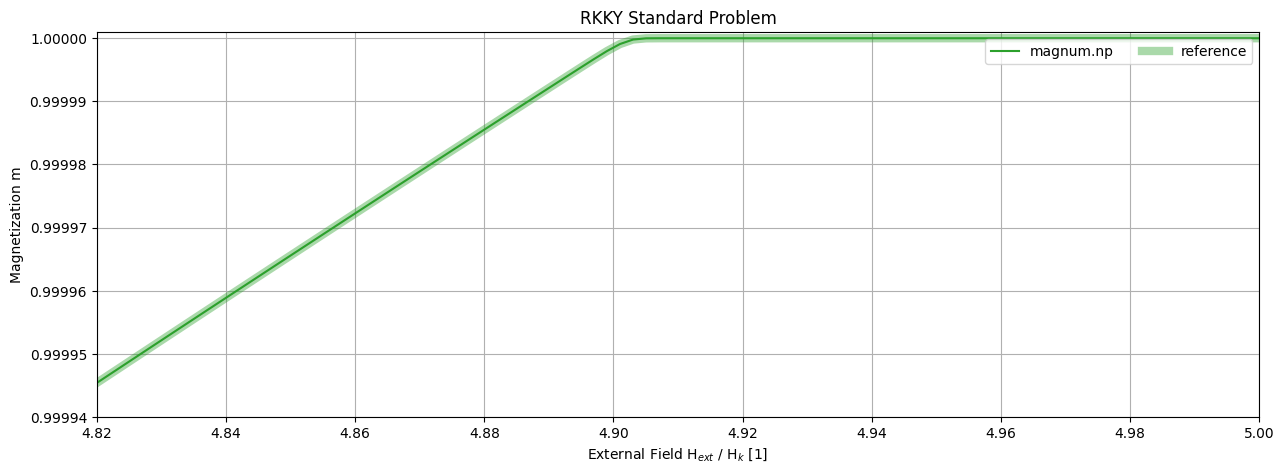

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = np.loadtxt("data/log.dat")
ref = np.loadtxt("ref/log.dat")

Hk = 2 * 1e5 / 1.

fig, ax = plt.subplots(figsize=(15,5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(data[:,6]/Hk, data[:,3], '-', color = cycle[2], label = "magnum.np")
ax.plot(ref[:,6]/Hk, ref[:,3], '-', color = cycle[2], linewidth = 6, alpha = 0.4, label = "reference")

ax.set_xlim([4.82,5.0])
ax.set_ylim([0.99994,1.000001])
ax.set_yticklabels(['0.99994', '0.99995', '0.99996', '0.99997', '0.99998', '0.99999', '1.00000'])
ax.set_title("RKKY Standard Problem")
ax.set_xlabel("External Field H$_{ext}$ / H$_k$ [1]")
ax.set_ylabel("Magnetization m")
ax.legend(ncol=3)
ax.grid()
fig.savefig("data/results.png")